# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn with the goal of characterising customers who churn and building a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook are to:
* look for significant clusters within the churn data - you might look separately at those who churn and those who don't or group them all together. 
* try to build and evaluate a predictive model for churn - predict the value of the CHURN_IND field in the data from some of the other fields


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid

from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist

In [2]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46206 entries, 1 to 46206
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CUST_ID                       46206 non-null  int64  
 1   ACCOUNT_TENURE                46206 non-null  int64  
 2   ACCT_CNT_SERVICES             46206 non-null  int64  
 3   AGE                           46130 non-null  float64
 4   CFU                           46206 non-null  object 
 5   SERVICE_TENURE                46206 non-null  int64  
 6   PLAN_ACCESS_FEE               46206 non-null  float64
 7   BYO_PLAN_STATUS               46206 non-null  object 
 8   PLAN_TENURE                   46206 non-null  int64  
 9   MONTHS_OF_CONTRACT_REMAINING  46206 non-null  int64  
 10  LAST_FX_CONTRACT_DURATION     46206 non-null  int64  
 11  CONTRACT_STATUS               46206 non-null  object 
 12  PREV_CONTRACT_DURATION        46206 non-null  int64  
 13  H

In [4]:
churn.describe().T

,count,mean,std,min,25%,50%,75%,max
CUST_ID,46206.0,42335.196879,22100.432751,1.00,24951.75,43261.00,61132.75,79500.00
ACCOUNT_TENURE,46206.0,45.874627,33.077927,0.00,14.00,44.00,77.00,120.00
ACCT_CNT_SERVICES,46206.0,1.555707,0.835529,1.00,1.00,1.00,2.00,4.00
AGE,46130.0,41.411836,15.263726,-4.00,28.00,40.00,52.00,116.00
SERVICE_TENURE,46206.0,50.318617,51.925537,0.00,11.00,35.00,69.00,259.00
PLAN_ACCESS_FEE,46206.0,51.364858,20.855419,8.18,36.36,54.54,72.72,234.54
PLAN_TENURE,46206.0,10.846708,9.769887,0.00,3.00,8.00,16.00,147.00
MONTHS_OF_CONTRACT_REMAINING,46206.0,8.237112,8.341476,0.00,0.00,7.00,16.00,24.00
LAST_FX_CONTRACT_DURATION,46206.0,20.349825,8.034631,0.00,24.00,24.00,24.00,36.00
PREV_CONTRACT_DURATION,46206.0,15.249968,10.982958,0.00,0.00,24.00,24.00,36.00


As an initial exploration of the data checking the descriptive statistics of the data. The min of AGE is -4, which is clearly a corrupt data. MONTHLY_SPEND max value is extremely far away from 75% value, which dictates existence of extreme outlier in this variable. Other variables seem not have much anomalies. We shall examine the AGE and  MONTHLY_SPEND more and shall remove abnormal data.

In [5]:
churn.isna().sum()

CUST_ID                             0
ACCOUNT_TENURE                      0
ACCT_CNT_SERVICES                   0
AGE                                76
CFU                                 0
SERVICE_TENURE                      0
PLAN_ACCESS_FEE                     0
BYO_PLAN_STATUS                     0
PLAN_TENURE                         0
MONTHS_OF_CONTRACT_REMAINING        0
LAST_FX_CONTRACT_DURATION           0
CONTRACT_STATUS                     0
PREV_CONTRACT_DURATION              0
HANDSET_USED_BRAND                  0
CHURN_IND                           0
MONTHLY_SPEND                       0
COUNTRY_METRO_REGION                1
STATE                               1
RECON_SMS_NEXT_MTH              17790
RECON_TELE_NEXT_MTH             17790
RECON_EMAIL_NEXT_MTH            17790
dtype: int64

In [6]:
churn = churn.drop(['CUST_ID','RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH', 'RECON_EMAIL_NEXT_MTH'], axis=1)

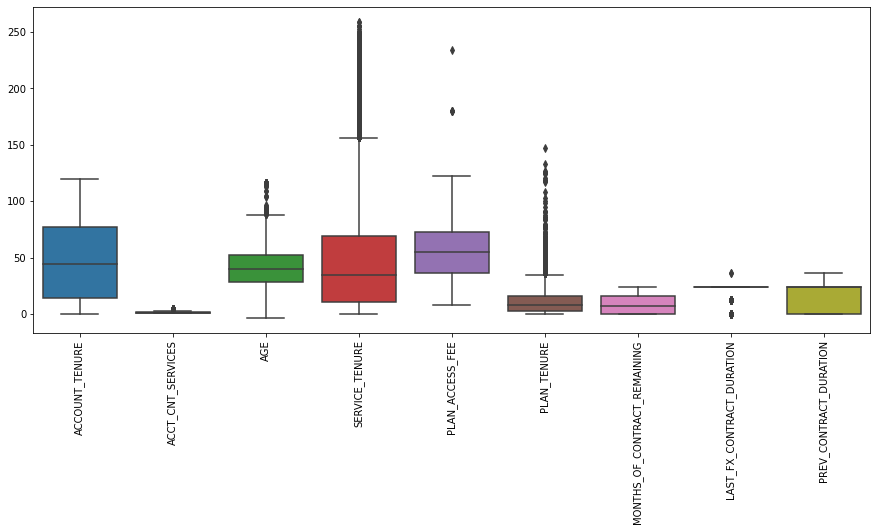

In [7]:
plt.figure(figsize=(15,6))
sns.boxplot(data=churn.loc[:, ~churn.columns.isin(['MONTHLY_SPEND','CHURN_IND'])])
var = plt.xticks(rotation=90)

The distribution of the numeric variables does not have very extreme outliers. As the outliers are not very extreme, we shall keep these outliers for these variables.

C:\Users\Masud\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='MONTHLY_SPEND'>

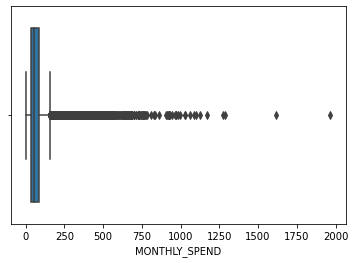

In [8]:
sns.boxplot(churn['MONTHLY_SPEND'])

There are lots of extreme outliers in MONTHLY_SPEND variable. We shall remove the values outside of 1.5*IQR.

C:\Users\Masud\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='AGE'>

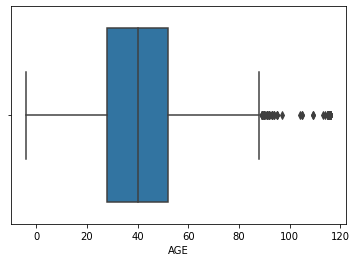

In [9]:
sns.boxplot(churn['AGE'])

There some negative values in AGE variable, which is clearly corrupt data. We shall remove values less than 10 from dataset.

In [10]:
ms_p25 = churn['MONTHLY_SPEND'].quantile(0.25)
ms_p75 = churn['MONTHLY_SPEND'].quantile(0.75)
ms_iqr = ms_p75 - ms_p25
ms_u_lim = ms_p75 + 1.5 * ms_iqr
ms_l_lim = ms_p25 - 1.5 * ms_iqr

churn_outlier_removed = churn[(churn['MONTHLY_SPEND'] >= ms_l_lim) & (churn['MONTHLY_SPEND'] <= ms_u_lim)]
churn_outlier_removed = churn_outlier_removed[(churn_outlier_removed['AGE'] >= 10)]

churn_outlier_removed = churn_outlier_removed.dropna()
print(churn.shape[0] - churn_outlier_removed.shape[0], 'rows removed as outlier, corrupt and null data')

3747 rows removed as outlier, corrupt and null data


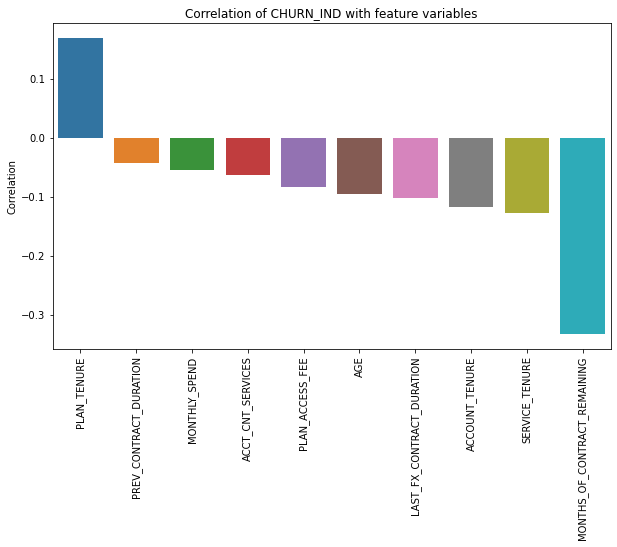

In [11]:
corr_churn_ind = churn_outlier_removed.corr()['CHURN_IND'].sort_values(ascending = False).to_frame().drop('CHURN_IND')
plt.figure(figsize=(10,6))
plt.title('Correlation of CHURN_IND with feature variables')
g= sns.barplot(x=corr_churn_ind.index.values, y =corr_churn_ind['CHURN_IND'], data=corr_churn_ind)
tick_marks = np.arange(len(corr_churn_ind.index.values))
var = plt.xticks(tick_marks,corr_churn_ind.index.values, rotation=90)
var = plt.ylabel('Correlation')
plt.show()

We shall use the CHURN_IND as response variable. The remaining columns will be used as features of the model. The plot shows co-relations between CHURN_IND and rest of numerical variables. PLAN_TENURE has positive corr.  MONTHS_OF_CONTRACT_REMAINING, SERVICE_TENURE have strongest negative corr.

In [12]:
churn_df = churn_outlier_removed.copy()

churn_df['CFU_code'] = pd.Categorical(churn_df['CFU']).codes
churn_df['BYO_PLAN_STATUS_code'] = pd.Categorical(churn_df['BYO_PLAN_STATUS']).codes
churn_df['CONTRACT_STATUS_code'] = pd.Categorical(churn_df['CONTRACT_STATUS']).codes
churn_df['HANDSET_USED_BRAND_code'] = pd.Categorical(churn_df['HANDSET_USED_BRAND']).codes
churn_df['COUNTRY_METRO_REGION_code'] = pd.Categorical(churn_df['COUNTRY_METRO_REGION']).codes
churn_df['STATE_code'] = pd.Categorical(churn_df['STATE']).codes

churn_coded = churn_df[['ACCOUNT_TENURE', 'ACCT_CNT_SERVICES', 'AGE', 'SERVICE_TENURE', 'PLAN_ACCESS_FEE',  'PLAN_TENURE',
               'MONTHS_OF_CONTRACT_REMAINING', 'LAST_FX_CONTRACT_DURATION', 'PREV_CONTRACT_DURATION', 'CHURN_IND',
               'MONTHLY_SPEND', 'CFU_code', 'BYO_PLAN_STATUS_code', 'CONTRACT_STATUS_code', 'HANDSET_USED_BRAND_code',
               'COUNTRY_METRO_REGION_code', 'STATE_code']]
churn_df.loc[(churn_df['CHURN_IND'] == 1), 'CHURN_IND'] = 'Yes'
churn_df.loc[(churn_df['CHURN_IND'] == 0), 'CHURN_IND'] = 'No'

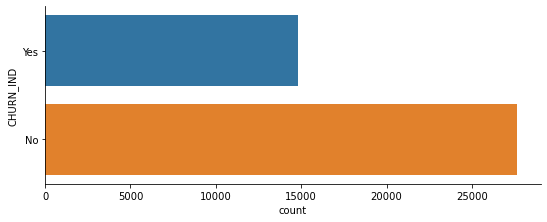

In [13]:
ax = sns.catplot(y="CHURN_IND", kind="count", data=churn_df, height=3, aspect=2.5, orient='h')

The plot shows the comparison between number of churn vs no churn. More customer is churning than customer continuing with the service provider.

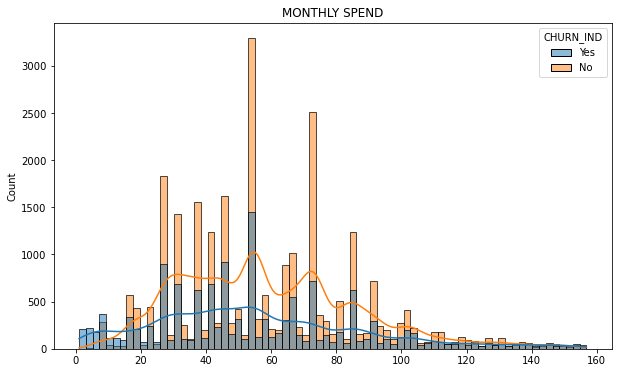

In [14]:
plt.figure(figsize=(10,6))
ax = sns.histplot(data = churn_df, x = 'MONTHLY_SPEND', hue='CHURN_IND',kde=True)
plt.title('MONTHLY SPEND')
ax.set(xlabel=None)
plt.show()

Distribution of monthly send seems normal. Most popular montly spend value is \\$55. Majority of the customers spend between \\$20 and \\$100.

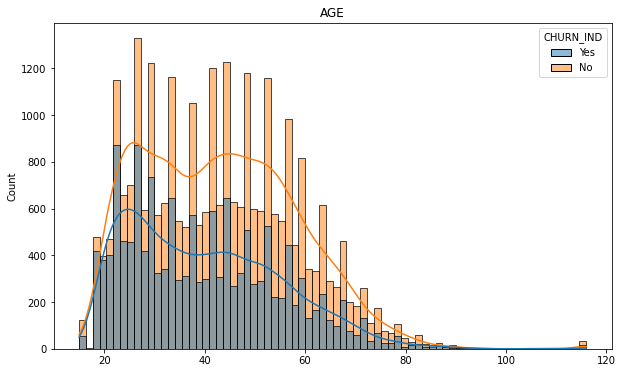

In [15]:
plt.figure(figsize=(10,6))
ax = sns.histplot(data = churn_df, x = 'AGE', hue='CHURN_IND',kde=True)
plt.title('AGE')
ax.set(xlabel=None)
plt.show()

The distribution of AGE looks normal as majority of data between 12 and 70 as expected. The distribution suggests younger people churn more.

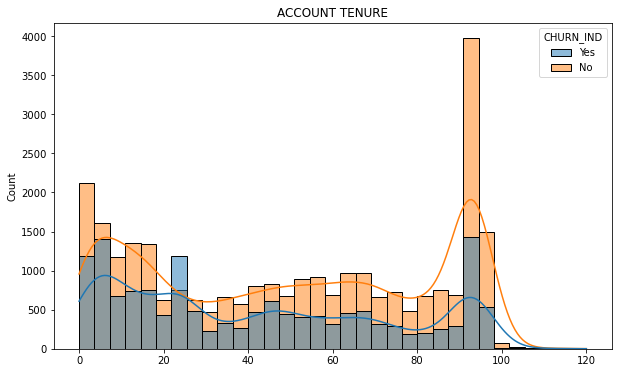

In [16]:
plt.figure(figsize=(10,6))
ax = sns.histplot(data = churn_df, x = 'ACCOUNT_TENURE', hue='CHURN_IND',kde=True)
plt.title('ACCOUNT TENURE')
ax.set(xlabel=None)
plt.show()

There is spike at both ends. Possible reason could be there was marketing campaign resulted huge customer onboarding.

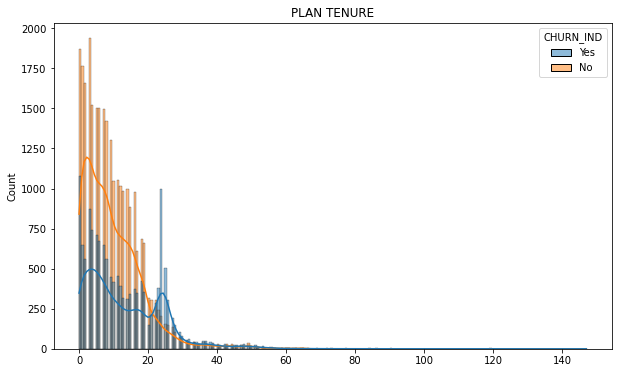

In [17]:
plt.figure(figsize=(10,6))
ax = sns.histplot(data = churn_df, x = 'PLAN_TENURE', hue='CHURN_IND',kde=True)
plt.title('PLAN TENURE')
ax.set(xlabel=None)
plt.show()

Majority of the customers are on month-to-month plan.

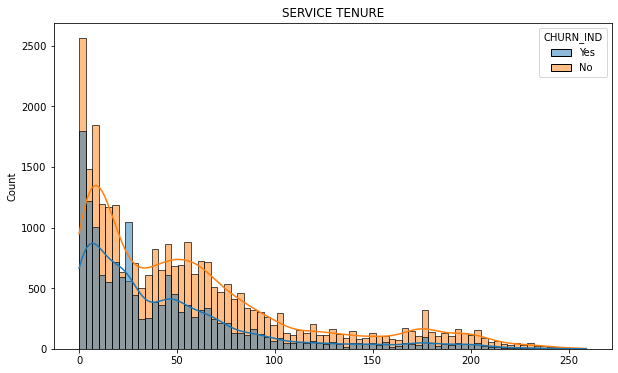

In [18]:
plt.figure(figsize=(10,6))
ax = sns.histplot(data = churn_df, x = 'SERVICE_TENURE', hue='CHURN_IND',kde=True)
plt.title('SERVICE TENURE')
ax.set(xlabel=None)
plt.show()

Both type of customer type concentrate at lower tenure. The customer newly joined are like to churn. Interesting to see even customers do not churn also concentrate at lower end! Possible reason might there might be a huge surge of customer onboarding recently.

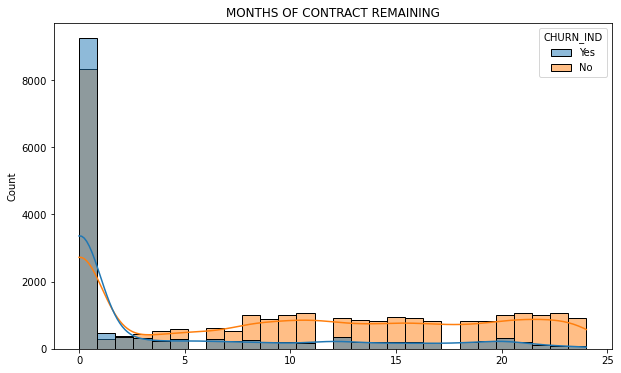

In [19]:
plt.figure(figsize=(10,6))
ax = sns.histplot(data = churn_df, x = 'MONTHS_OF_CONTRACT_REMAINING', hue='CHURN_IND',kde=True)
plt.title('MONTHS OF CONTRACT REMAINING')
ax.set(xlabel=None)
plt.show()

Again MONTHS_OF_CONTRACT_REMAINING also shows majority of the customers are on month-to-month plan are are at huge risk of churn.

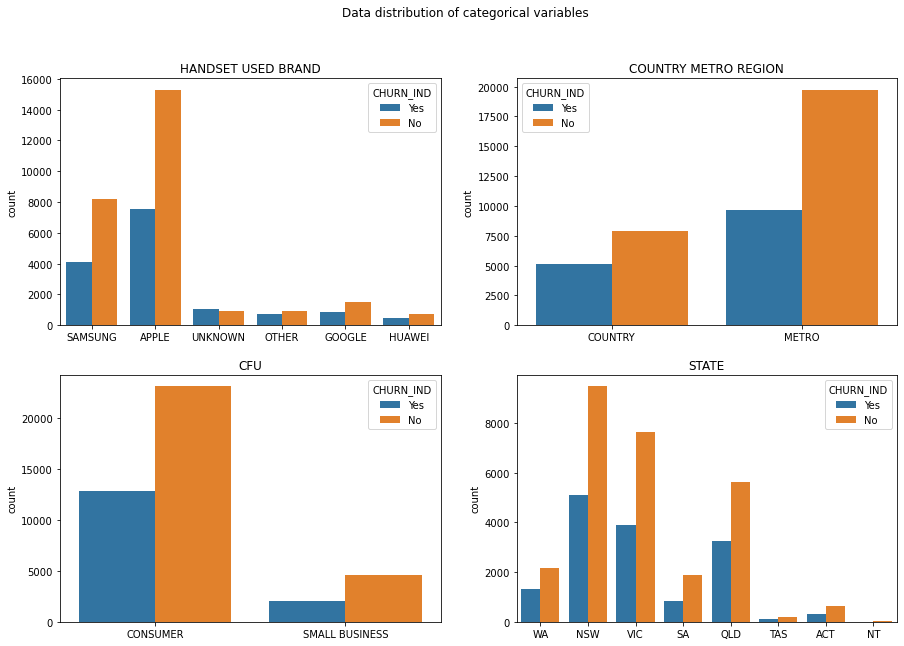

In [20]:
fig, ax = plt.subplots(figsize=(15,10), ncols=2, nrows=2)
fig.suptitle('Data distribution of categorical variables')

sns.countplot(x='HANDSET_USED_BRAND', data=churn_df, hue = 'CHURN_IND', ax=ax[0,0])
ax[0,0].set_title('HANDSET USED BRAND')
ax[0,0].set(xlabel=None)

sns.countplot(x='COUNTRY_METRO_REGION', data=churn_df, hue = 'CHURN_IND', ax=ax[0,1])
ax[0,1].set_title('COUNTRY METRO REGION')
ax[0,1].set(xlabel=None)

sns.countplot(x='CFU', data=churn_df, hue = 'CHURN_IND', ax=ax[1,0])
ax[1,0].set_title('CFU')
ax[1,0].set(xlabel=None)

sns.countplot(x='STATE', data=churn_df, hue = 'CHURN_IND', ax=ax[1,1])
ax[1,1].set_title('STATE')
ax[1,1].set(xlabel=None)
plt.show()

HANDSET_USED_BRAND plot shows Apple are the most popular handset brand followed by Samsung. Churn pattern are similar among the two most popular handset brands.

Text(0.5, 1.0, 'Monthly spend by handset brand')

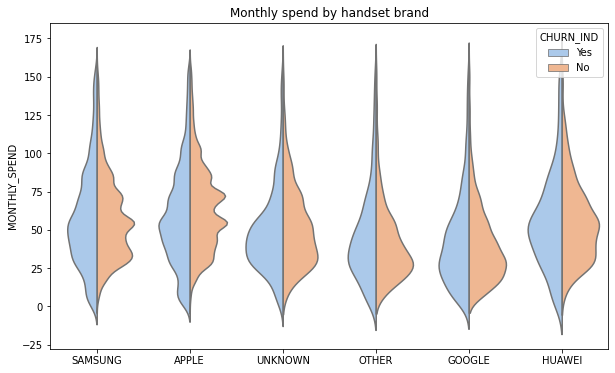

In [21]:
plt.figure(figsize=(10,6))
ax = sns.violinplot(x='HANDSET_USED_BRAND', y='MONTHLY_SPEND', hue = 'CHURN_IND', data=churn_df,
               split=True, palette="pastel", inner=None)
ax.set(xlabel=None)
plt.title('Monthly spend by handset brand')

High end handset brand i.e., Apple, Samsung do not have very significant spending pattern than low end handset brand i.e., Huawei, Google etc. 

In [22]:
churn_count = churn_df[['ACCT_CNT_SERVICES','CHURN_IND']].value_counts().unstack()
churn_count['Churn%'] = churn_count['Yes']/(churn_count['No'] + churn_count['Yes'])
churn_count['Churn%'] = churn_count['Churn%'].round(decimals = 4)

churn_count

CHURN_IND,No,Yes,Churn%
ACCT_CNT_SERVICES,,,
1,16677,9793,0.3700
2,6845,3394,0.3315
3,2692,1098,0.2897
4,1418,542,0.2765


The lowest churn comes from customers who signed up for 4 service. The highest churn comes from customers with 1 services. 
The more the custoemr sign up for servies less likely to churn

We shall divide the dataset into two separate group, the first one for positive churn and second one for negative churn customer groups.

In [23]:
churn_pos = churn_coded[churn_coded["CHURN_IND"] == 1]
churn_neg = churn_coded[churn_coded["CHURN_IND"] == 0]

initial_feature_names = churn_coded.columns
churn_pos_values = churn_pos.values
churn_neg_values = churn_neg.values

print(churn_pos.shape,churn_neg.shape)

(14827, 17) (27632, 17)


As there are not appropriate method to visualize cluster for high dimension data, we shall apply dimensionality reduction technique Principal Components Analysis (PCA) to find the features explain the most of the variance of the data for the both group of customers separately.

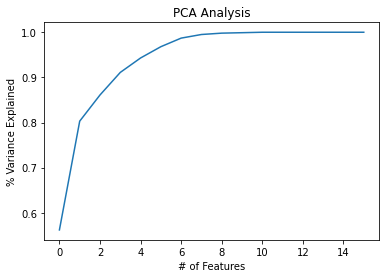

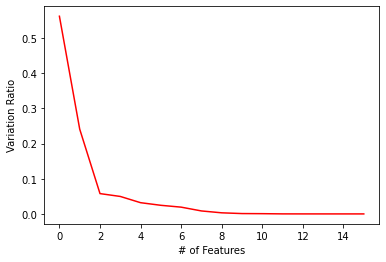

In [24]:
def plot_pca(data,n_components=0):
    if(n_components==0): n_components = data.shape[1]-1
    pca = PCA(n_components)
    pca_data = pca.fit_transform(data)
    var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3))
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Features')
    plt.title('PCA Analysis')
    plt.plot(var)
    plt.show()
    plt.ylabel('Variation Ratio')
    plt.xlabel('# of Features')
    plt.plot(pca.explained_variance_ratio_,color='red')
    plt.show()

    
plot_pca(churn_pos_values)

Positive churn customer group shows first two principal components can explain more than 80% of the variance, which is really good, as we use these two features to visualize the cluster.

In [25]:
from sklearn.decomposition import PCA

model = PCA(n_components=2).fit(churn_pos_values)
churn_pos_pca = model.transform(churn_pos_values)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(sorted(dic.items()))

var=np.cumsum(np.round(model.explained_variance_ratio_, decimals=3))
print("Positive churn customer group first two principal components")
df

Positive churn customer group first two principal components


,0,1
0,PC1,SERVICE_TENURE
1,PC2,MONTHLY_SPEND


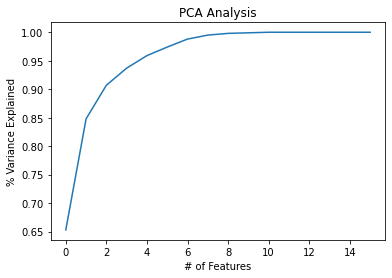

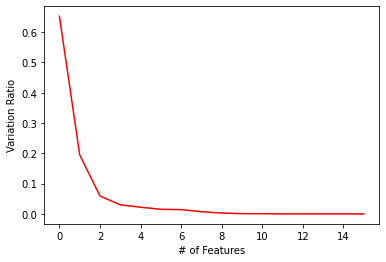

In [26]:
plot_pca(churn_neg_values)

Negative churn customer group shows first two principal components can explain close to 90% of the variance,  we use these two features to visualize the cluster.

In [27]:
model = PCA(n_components=2).fit(churn_neg_values)
churn_neg_pca = model.transform(churn_neg_values)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(sorted(dic.items()))

var=np.cumsum(np.round(model.explained_variance_ratio_, decimals=3))
print("Negative churn customer group first two principal components")
df

Negative churn customer group first two principal components


,0,1
0,PC1,SERVICE_TENURE
1,PC2,MONTHLY_SPEND


In [28]:
churn_pos_pca_frame = pd.DataFrame(churn_pos_pca)
churn_pos_pca_frame.columns = ['MONTHLY_SPEND', 'SERVICE_TENURE']

churn_pos_neg_frame = pd.DataFrame(churn_neg_pca)
churn_pos_neg_frame.columns = ['MONTHLY_SPEND', 'SERVICE_TENURE']

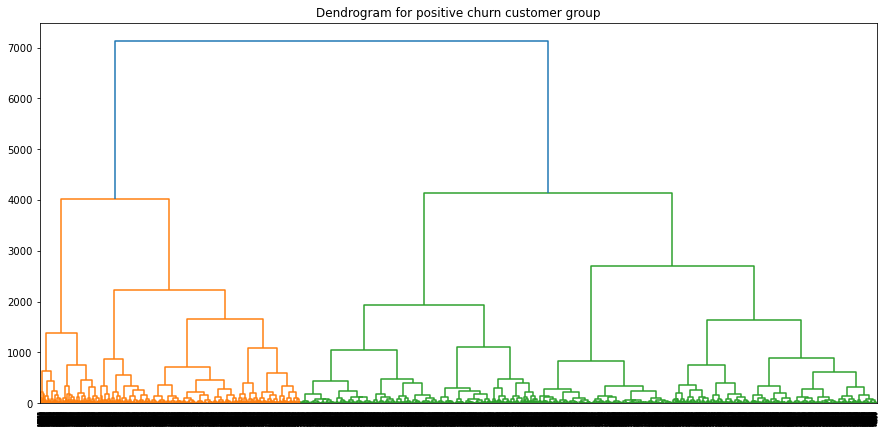

In [29]:
dist = pdist(churn_pos_pca, 'euclidean')
linkage_matrix = linkage(dist,method = 'ward')  # or 'ward'

plt.figure(figsize=(15,7))
dendrogram(linkage_matrix)
plt.title('Dendrogram for positive churn customer group')
plt.show()

From the dendrogram for positive churn group customers we can see the optimal number of cluster is 2 or 4. We shall build KMeam model for 4 clusters with this group.

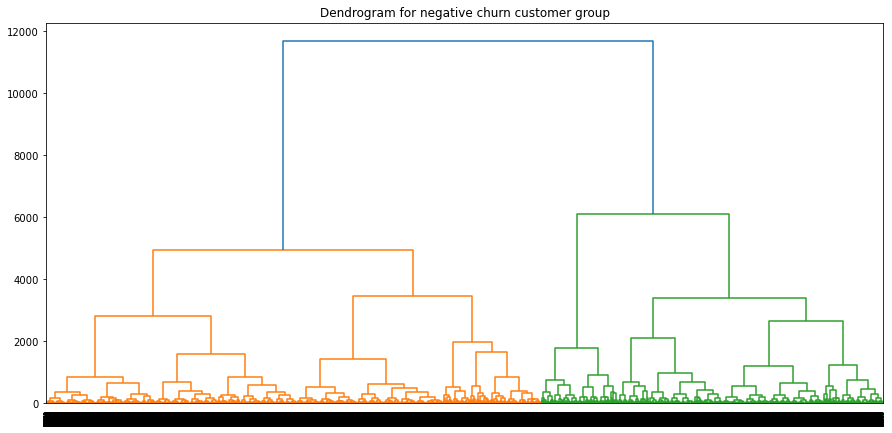

In [30]:
dist = pdist(churn_neg_pca, 'euclidean')
linkage_matrix = linkage(dist,method = 'ward')  # or 'ward'

plt.figure(figsize=(15,7))
dendrogram(linkage_matrix)
plt.title('Dendrogram for negative churn customer group')
plt.show()

From the dendrogram for negative churn group customers also shows the optimal number of cluster is 2 or 4. We shall build KMeam model for 4 clusters for this group.

In [31]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(churn_pos_pca)
if 'label' in churn_pos.columns:
    churn_pos = churn_pos.drop('label',axis=1)
    
churn_pos.insert(loc=0, column='label', value=kmeans.predict(churn_pos_pca))

In [32]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(churn_neg_pca)
if 'label' in churn_neg.columns:
    churn_neg = churn_neg.drop('label',axis=1)
    
churn_neg.insert(loc=0, column='label', value=kmeans.predict(churn_neg_pca))

In [33]:
print('Number of customers at cluster')
churn_pos.groupby("label").agg({"label": "count"})

Number of customers at cluster


,label
label,
0,3318
1,1533
2,5823
3,4153


<Figure size 1080x1080 with 0 Axes>

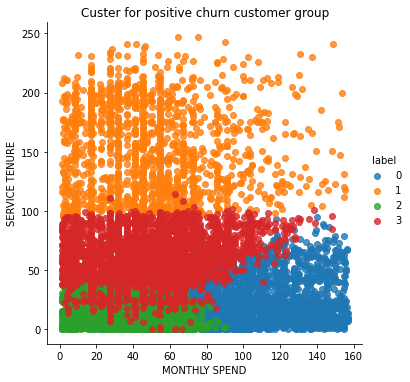

In [34]:
plt.figure(figsize=(15,15))
ax = sns.lmplot(x='MONTHLY_SPEND', y='SERVICE_TENURE', data=churn_pos, fit_reg=False, hue='label')
plt.xlabel("MONTHLY SPEND")
plt.ylabel("SERVICE TENURE")
plt.title('Custer for positive churn customer group')
plt.show()

Group 2 green colour are shoppers or temporary visitor. These group are like to churn out soon. 
Group 0 blue colour spend high amount but very sensitive to value of money, better product or service offer from competitor can cause the customer churn. Better campaign might be required to win back these group to stay longer.
Group 3 red colour moderate customer group. Majority of customers are concentrated into this group. This group spends moderate amount and stay for moderate period.
Group 1 are less dense customer group, but this group is loyal to the operator.

In [35]:
print('Number of customers at cluster')
churn_neg.groupby("label").agg({"label": "count"})

Number of customers at cluster


,label
label,
0,8898
1,8752
2,4072
3,5910


<Figure size 1080x1080 with 0 Axes>

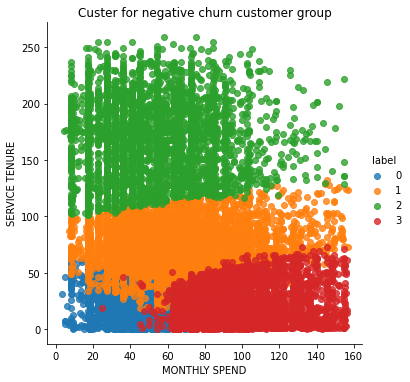

In [36]:
plt.figure(figsize=(15,15))
sns.lmplot(x='MONTHLY_SPEND', y='SERVICE_TENURE', data=churn_neg, 
           fit_reg=False, # No regression line
           hue='label') #Color by evolution stage
plt.xlabel("MONTHLY SPEND")
plt.ylabel("SERVICE TENURE")
plt.title('Custer for negative churn customer group')
plt.show()

Cluster for negative churn customer group are very similar to the positive churn group.
Group 2 green colour are shoppers or temporary visitor. These group are like to churn out soon. 
Group 0 blue colour spend high amount but very sensitive to value of money, better product or service offer from competitor can cause the customer churn. Better campaign might be required to win back these group to stay longer.
Group 3 red colour moderate customer group. Majority of customers are concentrated into this group. This group spends moderate amount and stay for moderate period.
Group 1 are less dense customer group, but this group is loyal to the operator.

In [37]:
min_max=MinMaxScaler()

df_data = churn_coded.loc[:, ~churn_coded.columns.isin(['CHURN_IND'])]
df_label = churn_coded['CHURN_IND']
df_scale=min_max.fit_transform(df_data)

In [38]:
x_trains, x_tests, y_trains, y_tests=train_test_split(df_scale, df_label, test_size=0.3, random_state=0)

In [39]:
logisticRegr = LogisticRegression(penalty='l1',C=1e9,fit_intercept=True, max_iter=10000, solver='saga')
logisticRegr.fit(x_trains, y_trains)
lg_pred = logisticRegr.predict(x_tests)
print('Logistic Regression Accuracy Score:', logisticRegr.score(x_tests, y_tests))
print ("Classification Report on test data")
print(classification_report(y_tests,lg_pred))

Logistic Regression Accuracy Score: 0.7224054011618778
Classification Report on test data
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      8324
           1       0.63      0.49      0.55      4414

    accuracy                           0.72     12738
   macro avg       0.69      0.67      0.68     12738
weighted avg       0.71      0.72      0.71     12738



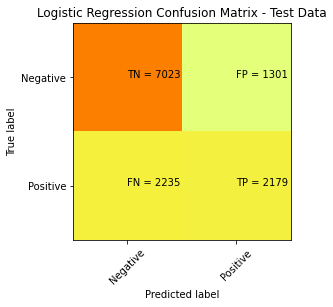

In [40]:
cm = confusion_matrix(y_tests, lg_pred)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Logistic Regression Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

FP = 1301 and FN = 2235 are the wrongly classified by the model. TN = 7023 and TP = 2179 are the correcly classifyed by the model.

In [41]:
tn, fp, fn, tp = confusion_matrix(y_tests, lg_pred).ravel()

accuracy = logisticRegr.score(x_tests, y_tests)
print('Logistic regression performance score.')
print('accuracy:', accuracy)
precision = classification_report(y_tests,lg_pred,output_dict=True)['weighted avg']['precision']
print('precision:', precision)

recall = classification_report(y_tests,lg_pred,output_dict=True)['weighted avg']['recall']
print('recall:', recall)

f1 = classification_report(y_tests,lg_pred,output_dict=True)['weighted avg']['f1-score']
print('f1:', f1)

specificity = tn / (tn+fp)
print('specificity:', specificity)

sensitivity = tp / (tp + fn)
print('sensitivity:', sensitivity)

result_table_filter = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
result_table_filter_all = pd.DataFrame(columns=['classifiers', 'accuracy','precision','recall','f1','sensitivity','specificity','auc'])
fpr, tpr, _ = roc_curve(y_tests,  lg_pred)
auc = roc_auc_score(y_tests, lg_pred)

result_table_filter = result_table_filter.append({'classifiers':'Logistic Regression',
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

result_table_filter_all = result_table_filter_all.append({'classifiers':'Logistic Regression', 'accuracy':accuracy, 'precision':precision,
                                                         'recall':recall,'f1':f1,'sensitivity':sensitivity,
                                                         'specificity':specificity,'auc':auc}, ignore_index=True)

Logistic regression performance score.
accuracy: 0.7224054011618778
precision: 0.7126945476873905
recall: 0.7224054011618778
f1: 0.7133564837453238
specificity: 0.8437049495434887
sensitivity: 0.493656547349343


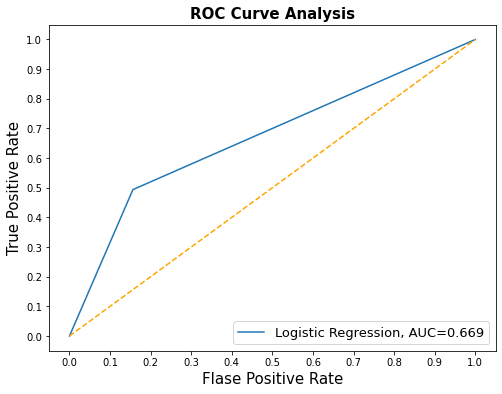

In [42]:
fig = plt.figure(figsize=(8,6))

for i in result_table_filter.index:
    plt.plot(result_table_filter.loc[i]['fpr'], 
             result_table_filter.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(result_table_filter["classifiers"][i], result_table_filter.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

ROC compares the positive hits and false alarms. The top edge closer to the top left are better model. We have achieved 0.669 which is not an excellent performance but not very bad. 

With available data we have tried to build a cluster and predictive model. While we have achieved some clear clustering, the predictive model did not perform very good with AUC score achieved 0.669. In future we could try to source more variables and more data that might help to improve the model performance.